In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

from qtt.algorithms.functions import (gauss_ramsey, fit_gauss_ramsey, 
                                      plot_gauss_ramsey_fit)
from qutip import (basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, 
                   mesolve, identity, Qobj, destroy, qeye, expect, parallel_map)

from qubit_zz_coupling.core import (setup_operators, solve_t1, solve_t2,
                                    plot_t1, plot_t2, rabi_results, make_n,
                                    ramsey_expectation_drive_both,
                                    ramsey_population_drive_both,
                                    ramsey_expectation_drive_sep,
                                    ramsey_population_drive_sep,
                                    make_3tensor,
                                    rabi_results_multiplex)
from qubit_zz_coupling.utils import  f2w, fq_shift, make_population, ramsey


In [77]:
USE_MP = True # Depends on system

# Define system parameters
SYSTEM_PARAMS_base = {
    "f_q1": 3.2,  # GHz, Qubit 1 frequency (3.2)
    "f_q2": 3.35,  # GHz, Qubit 2 frequency
    "f_tls": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "T1": {"q1": 20000, "q2": 25000, "tls": 1e8},  # Relaxation rates
    "T2": {"q1": 15000, "q2": 18000, "tls": 1e8},  # Dephasing rates
    "J_zz": 0.0, # Jzz coupling
    "J_tls": 0.0,  # GHz, Coupling strength between Qubit 1 and TLS
    "omega1": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "omega2": 2*np.pi * 0.01, # drive amplitude (sets π/2 duration)
    "time_points": np.linspace(0, 300, 105),  # Time points in μs
    "ver1": True,
    "single": False
}

opts = {"nsteps": 1000000}

# Rabi Oscillation

In [78]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

t=np.linspace(0,500,1000) #ns
w_d = f2w(SYSTEM_PARAMS["f_q1"]) # drive at q1 freq
print(w_d)
#w_d = 3.2 # drive at q1 freq
omega = SYSTEM_PARAMS["omega1"]

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

my_cops = [c_ops[0],c_ops[3]]
res_s = rabi_results(t, w_d, omega, H, sx_q1, c_ops=c_ops, opts=opts, psi0=make_3tensor(1,0,0))
n = make_n(sm_q1)
res = expect(n, res_s.states)

20.106192982974676


pi pulse=5.00e+01
pi pulse: 50.050050050050054


Text(0, 0.5, 'Excitation expectation value')

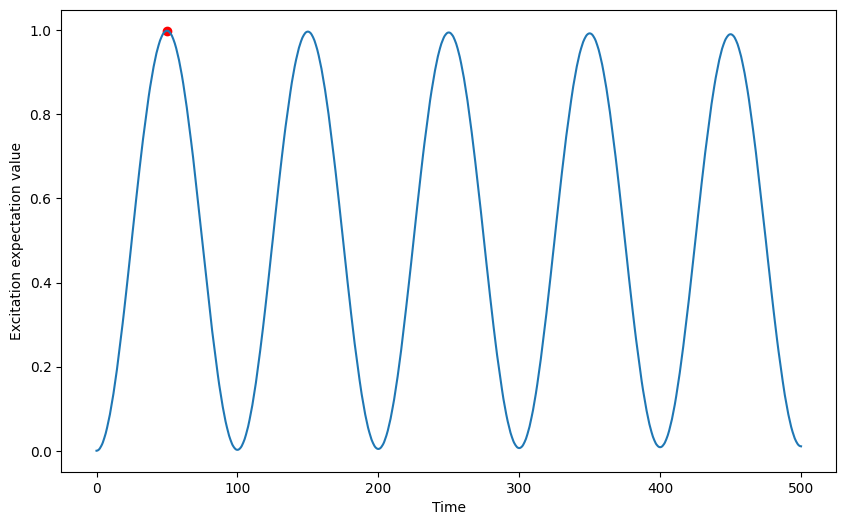

In [79]:
pi_pulse=np.pi/omega
print(f"pi pulse={pi_pulse:.2e}")

# rabi osc pi pulse
i=np.argmax(res)
print("pi pulse:", t[i])

fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.scatter(t[i],res[i],color="red") #pi pulse peak
axes.plot(t, res)
axes.set_xlabel('Time')
axes.set_ylabel('Excitation expectation value')
#axes.set_title(f'Rabi Oscillation pulse={pi_pulse:.3f}');


In [73]:
def rabi(detuning):

    res_s = rabi_results(t, w_d+f2w(detuning), omega, H, sx_q1, c_ops=c_ops, opts=opts, psi0=make_3tensor(1,0,0))
    n = make_n(sm_q1)
    res = expect(n, res_s.states)
    return res

det=np.linspace(-0.1,0.01,300) #GHz

# qutip's parallelism "map()" like function to evaluate all Detunings
chevron=list(parallel_map(rabi,det,progress_bar=True))

10.0%. Run time:   1.96s. Est. time left: 00:00:00:17
20.0%. Run time:   1.99s. Est. time left: 00:00:00:07
30.0%. Run time:   2.06s. Est. time left: 00:00:00:04
40.0%. Run time:   3.14s. Est. time left: 00:00:00:04
50.0%. Run time:   3.19s. Est. time left: 00:00:00:03
60.0%. Run time:   3.30s. Est. time left: 00:00:00:02
70.0%. Run time:   4.42s. Est. time left: 00:00:00:01
80.0%. Run time:   4.48s. Est. time left: 00:00:00:01
90.0%. Run time:   4.56s. Est. time left: 00:00:00:00
100.0%. Run time:   5.06s. Est. time left: 00:00:00:00
Total run time:   5.15s


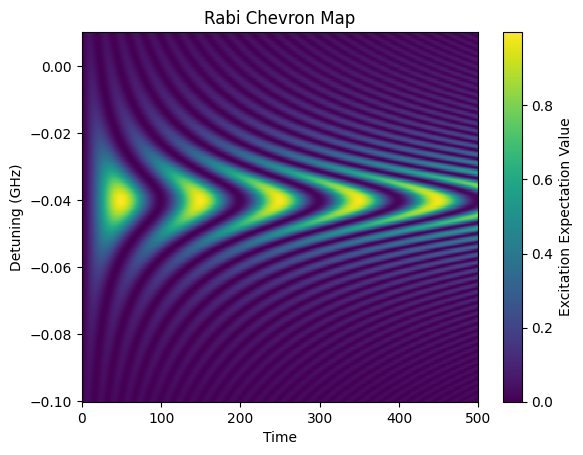

In [74]:
# Assuming 't' and 'Det' are defined from the previous code
T, Det = np.meshgrid(t, det)

plt.pcolor(T , Det, np.array(chevron))  # Plotting with correct units
plt.xlabel("Time")
plt.ylabel("Detuning (GHz)")
plt.title("Rabi Chevron Map")
plt.colorbar(label="Excitation Expectation Value")
plt.show()

# Rabi Multiplex

In [70]:
# Get fresh settings
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

t=np.linspace(0,500,1000) #ns
w_d = f2w(SYSTEM_PARAMS["f_q1"]) # drive at q1 freq
w_d2 = f2w(SYSTEM_PARAMS["f_q2"]) # drive at q1 freq

print(w_d)
#w_d = 3.2 # drive at q1 freq
omega = SYSTEM_PARAMS["omega1"]

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2, sm_q1, sm_q2 = setup_operators(SYSTEM_PARAMS)

20.106192982974676


In [75]:
def rabi(detuning):

    res_s = rabi_results_multiplex(t, w_d+f2w(detuning), w_d2+f2w(0.01), omega, H, sx_q1, sx_q2, c_ops=c_ops, opts=opts, psi0=make_3tensor(1,1,0))
    n = make_n(sm_q1)
    res = expect(n, res_s.states)
    return res

det=np.linspace(-0.1,0.01,300) #GHz

# qutip's parallelism "map()" like function to evaluate all Detunings
chevron=list(parallel_map(rabi,det,progress_bar=True))

10.0%. Run time:   3.46s. Est. time left: 00:00:00:31
20.0%. Run time:   3.54s. Est. time left: 00:00:00:14
30.0%. Run time:   3.59s. Est. time left: 00:00:00:08
40.0%. Run time:   6.29s. Est. time left: 00:00:00:09
50.0%. Run time:   6.45s. Est. time left: 00:00:00:06
60.0%. Run time:   7.44s. Est. time left: 00:00:00:04
70.0%. Run time:   9.13s. Est. time left: 00:00:00:03
80.0%. Run time:   9.32s. Est. time left: 00:00:00:02
90.0%. Run time:   9.68s. Est. time left: 00:00:00:01
100.0%. Run time:  10.49s. Est. time left: 00:00:00:00
Total run time:  10.58s


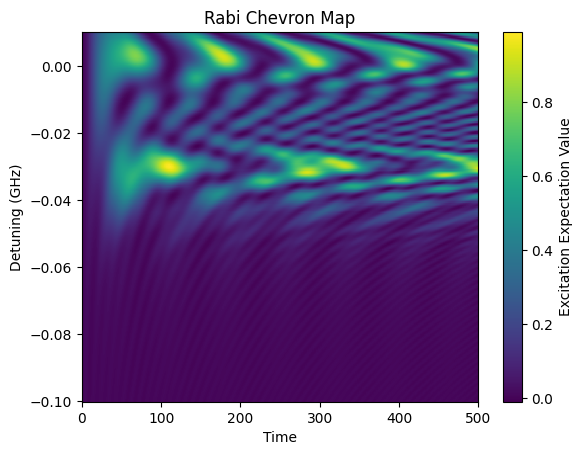

In [76]:
# Assuming 't' and 'Det' are defined from the previous code
T, Det = np.meshgrid(t, det)

plt.pcolor(T , Det, np.array(chevron))  # Plotting with correct units
plt.xlabel("Time")
plt.ylabel("Detuning (GHz)")
plt.title("Rabi Chevron Map")
plt.colorbar(label="Excitation Expectation Value")
plt.show()

# EOF